<a href="https://colab.research.google.com/github/Romanchenko-RS/ML/blob/main/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD%D1%87%D0%B5%D0%BD%D0%BA%D0%BE_%D0%A0_%D0%A1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка

Импорт необходимых библиотек

In [2]:
import pandas as pd
import bz2
import json
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
import pymorphy2
from nltk.probability import FreqDist
import re
from pymorphy2 import MorphAnalyzer
import re
from gensim import corpora
from gensim.models import LdaModel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline

Установка библиотеки pymorphy2

In [4]:
!pip install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 97.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=ff39da73514ef98824754aebbed5e49217f9c1c558229e4d9fc8638b9c22be45
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


Подготовка данных

In [ ]:
# Откроем файл
with bz2.open('/content/banki_responses.json.bz2', 'rt', encoding='utf-8') as file:
    # Чтение всего файла построчно
    reviews = [json.loads(line) for line in file]

# Количество загруженных отзывов
print(f"Количество отзывов: {len(reviews)}")

# Пример вывода первых нескольких отзывов
for review in reviews[:10]:
    print(review)

Количество отзывов: 201030
{'city': 'г. Воронеж', 'rating_not_checked': True, 'title': 'Ипотека на 5+', 'num_comments': 0, 'bank_license': 'лицензия № 1623', 'author': 'e.novikova', 'bank_name': 'ВТБ 24', 'datetime': '2015-06-08 11:06:56', 'text': 'Здравствуйте!  Хотелось бы выразить благодарность банку ВТБ24 г.Воронеж пл. Ленина и непосредственно специалисту по ипотечному кредитованию Мещеряковой Юлии Анатольевне. Это уже моя вторая ипотека в этом банке и у этого специалиста. Вопросов с подачей документов не было, быстрое принятие решения об одобрении всей необходимой суммы и никаких проблем с выдачей кредита. Удобно, что никуда не нужно ходить и со сторонними организациями не нужно договариваться. На оценку сотрудники банка приехали вовремя, страховку оформили перед выдачей кредита в отделении банка. Все быстро, четко, слаженно. На все мои вопросы о сравнении условий Юлия подробно отвечала, что сомнений никаких не возникло в каком именно банке брать (был выбор между сбербанком и втб2

In [3]:
# Загрузка данных построчно
data = []
with bz2.BZ2File('/content/banki_responses.json.bz2', 'r') as file:
    for line in file:
        data.append(json.loads(line.decode('utf-8')))

# Преобразование данных в DataFrame
df = pd.DataFrame(data)

# Проверка данных
print(df.head())

                 city  rating_not_checked  \
0          г. Воронеж                True   
1           г. Казань                True   
2  г. Санкт-Петербург                True   
3           г. Москва                True   
4        г. Волгоград                True   

                                 title  num_comments     bank_license  \
0                        Ипотека на 5+             0  лицензия № 1623   
1                       ЗВОНКИ СОСЕДЯМ             0  лицензия № 2289   
2                Ложная информация!!!!             0  лицензия № 2307   
3  Банкомат не зачислил деньги на счет             1  лицензия № 2557   
4   Невозможно закрыть карту 2(два)!!!             0  лицензия № 3354   

              author         bank_name             datetime  \
0         e.novikova            ВТБ 24  2015-06-08 11:06:56   
1  KZN\Vorontsova_NA  Русский Стандарт  2015-06-06 18:17:52   
2          Evgenia15              Союз  2015-06-07 19:08:33   
3        dolgov.work          Ситибанк

# Часть 1. Анализ текстов

1. Посчитайте количество отзывов в разных городах и на разные банки

In [ ]:
city_counts = df['city'].value_counts()
print("Количество отзывов по городам (шт.):")
print(city_counts)

bank_counts = df['bank_name'].value_counts()
print("\nКоличество отзывов по банкам (шт.):")
print(bank_counts)

Количество отзывов по городам (шт.):
city
г. Москва                                73715
г. Санкт-Петербург                       18614
г. Екатеринбург                           3211
г. Новосибирск                            3081
г. Нижний Новгород                        2596
                                         ...  
г. Москва/Хабаровск                          1
г. ст.советская                              1
г. Сочи, Краснодар, Туапсе                   1
г. Североуральск Свердловской области        1
г. Краснодарский край, ст.Павловская         1
Name: count, Length: 7151, dtype: int64

Количество отзывов по банкам (шт.):
bank_name
Сбербанк России            30977
Альфа-Банк                 13651
Русский Стандарт           10952
ВТБ 24                     10556
Хоум Кредит Банк           10130
                           ...  
Ипотека-Инвест                 1
Держава                        1
Банк на Красных Воротах        1
Ураллига                       1
Каспий                  

Видим, что в данных имеется длинный "хвост" из единичных занчений по отзывам и по банкам. Посчитаем доли, чтобы понимать порядок малочастотного сегмента.

In [ ]:
# Извлечение городов из данных
cities = df['city']

# Подсчет количества отзывов для каждого города
city_review_counts = cities.value_counts()

# Количество уникальных городов
unique_cities_count = len(city_review_counts)
print(f'Количество уникальных городов: {unique_cities_count}')

# Подсчет доли городов, у которых количество отзывов равно 1
single_review_cities_count = (city_review_counts == 1).sum()
single_review_cities_share = single_review_cities_count / unique_cities_count
print(f'Доля городов с единственным отзывом: {single_review_cities_share:.2%}')

Количество уникальных городов: 7151
Доля городов с единственным отзывом: 68.82%


In [ ]:
# Количество уникальных банков
unique_banks = df['bank_name'].nunique()
print(f'Количество уникальных банков: {unique_banks}')

# Подсчет количества отзывов по каждому банку
bank_counts = df['bank_name'].value_counts()

# Доля банков с одним отзывом
single_review_banks = (bank_counts == 1).sum()
single_review_banks_ratio = single_review_banks / unique_banks
print(f'Доля банков с одним отзывом: {single_review_banks_ratio:.2%}')

Количество уникальных банков: 733
Доля банков с одним отзывом: 16.78%


Как видим, почти 2/3 городов имеют один единственный отзыв, в то же время доля банков с одним отзывом значительно ниже.

2. Постройте гистограмы длин слов в символах и в словах

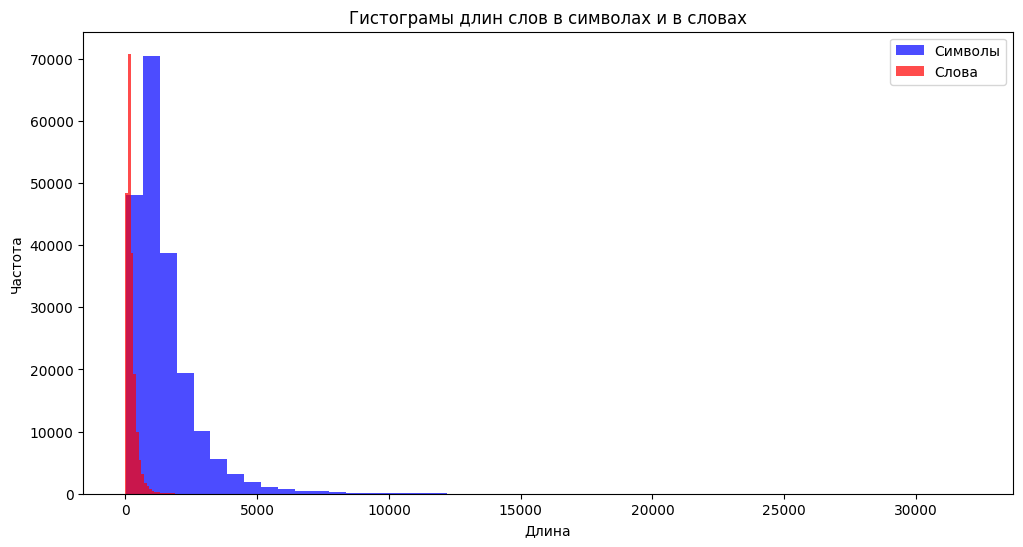

In [ ]:
df['review_length_chars'] = df['text'].apply(len)
df['review_length_words'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
plt.hist(df['review_length_chars'], bins=50, color='blue', alpha=0.7, label='Символы')
plt.hist(df['review_length_words'], bins=50, color='red', alpha=0.7, label='Слова')
plt.title('Гистограмы длин слов в символах и в словах')
plt.xlabel('Длина')
plt.ylabel('Частота')
plt.legend()
plt.show()

3. Найдите 10 самых частых:

а) слов

б) слов без стоп-слов

в) лемм

г) существительных

In [ ]:
# 10 самых частых слов

# Объединение всех текстов отзывов в один текст
all_texts = ' '.join(df['text'])

# Разбиение текста на слова (с удалением знаков пунктуации)
words = re.findall(r'\w+', all_texts.lower())

# Подсчет частоты каждого слова
word_counts = Counter(words)

# Получение 10 самых частых слов
most_common_words = word_counts.most_common(10)

# Вывод результата
print("10 самых частых слов:")
for word, count in most_common_words:
    print(f"'{word}': {count}")

10 самых частых слов:
'в': 1622690
'и': 1309947
'не': 1040758
'на': 861675
'что': 774913
'я': 701475
'с': 569010
'по': 456096
'мне': 388912
'банка': 344424


In [ ]:
# 10 самых частых слов без стоп-слов

# Загрузка стоп-слов для русского языка
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

# Объединение всех текстов отзывов в один большой текст
all_texts = ' '.join(df['text'])

# Очистка текста от знаков препинания и приведение к нижнему регистру
all_texts = re.sub(r'[^\w\s]', '', all_texts.lower())

# Разбиение текста на слова
words = all_texts.split()

# Фильтрация слов, исключая стоп-слова
filtered_words = [word for word in words if word not in russian_stopwords]

# Подсчет 10 самых частых слов
most_common_words = Counter(filtered_words).most_common(10)

# Вывод результата
print("10 самых частых слов без стоп-слов:")
for word, count in most_common_words:
    print(f'{word}: {count}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


10 самых частых слов без стоп-слов:
банка: 329916
банк: 252984
это: 225486
деньги: 158068
карту: 127211
карты: 120629
кредит: 107842
день: 92468
очень: 86708
банке: 84420


In [ ]:
# 10 самых частых лемм

# Инициализация лемматизатора
morph = pymorphy2.MorphAnalyzer()

# Загрузка стоп-слов для русского языка
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

# Функция для лемматизации и фильтрации слов
def lemmatize_and_filter(text):
    # Очистка текста от знаков препинания и приведение к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text.lower())
    words = text.split()
    # Лемматизация и фильтрация
    return [morph.parse(word)[0].normal_form for word in words if word not in russian_stopwords]

# Подсчет частот лемм
lemm_counts = Counter()

# Загрузка и обработка данных построчно
with bz2.BZ2File('/content/banki_responses.json.bz2', 'r') as file:
    for line in file:
        review = json.loads(line.decode('utf-8'))
        text = review.get('text', '')
        lemmatized_words = lemmatize_and_filter(text)
        lemm_counts.update(lemmatized_words)

# Получение 10 самых частых лемм
most_common_lemm = lemm_counts.most_common(10)

# Вывод результата
print("10 самых частых лемм:")
for lemm, count in most_common_lemm:
    print(f'{lemm}: {count}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


10 самых частых лемм:
банк: 795904
карта: 400661
это: 246829
деньга: 216847
день: 207962
кредит: 205540
мой: 201011
который: 182872
счёт: 170510
отделение: 168271


Почему-то стоп-слово "мой" попало в выборку данных

In [ ]:
# Инициализация лемматизатора
morph = pymorphy2.MorphAnalyzer()

# Загрузка стоп-слов для русского языка
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

# Функция для лемматизации и фильтрации существительных
def extract_nouns(text):
    # Очистка текста от знаков препинания и приведение к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text.lower())
    words = text.split()
    # Лемматизация и фильтрация существительных
    nouns = []
    for word in words:
        if word not in russian_stopwords:
            parse = morph.parse(word)[0]
            if 'NOUN' in parse.tag:
                nouns.append(parse.normal_form)
    return nouns

# Подсчет частот существительных
noun_counts = Counter()

# Загрузка и обработка данных построчно
with bz2.BZ2File('/content/banki_responses.json.bz2', 'r') as file:
    for line in file:
        review = json.loads(line.decode('utf-8'))
        text = review.get('text', '')
        nouns = extract_nouns(text)
        noun_counts.update(nouns)

# Получение 10 самых частых существительных
most_common_nouns = noun_counts.most_common(10)

# Вывод результата
print("10 самых частых существительных:")
for noun, count in most_common_nouns:
    print(f'{noun}: {count}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


10 самых частых существительных:
банк: 795904
карта: 400661
деньга: 216847
день: 207962
кредит: 205540
счёт: 170510
отделение: 168271
клиент: 168096
сотрудник: 165862
сумма: 138283


3. Постройте кривые Ципфа и Хипса

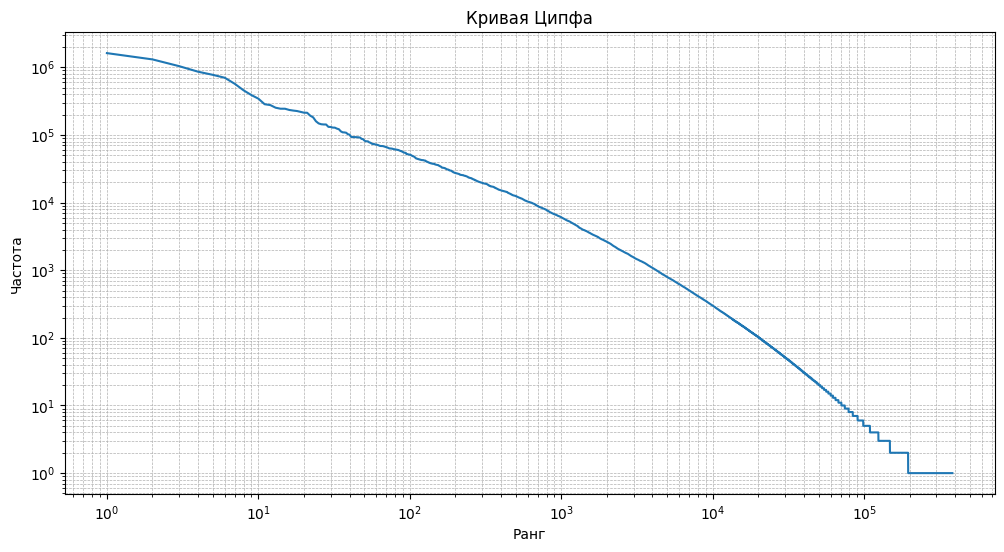

In [ ]:
# Загрузка данных построчно
data = []
with bz2.BZ2File('/content/banki_responses.json.bz2', 'r') as file:
    for line in file:
        data.append(json.loads(line.decode('utf-8')))

# Преобразование данных в DataFrame
df = pd.DataFrame(data)

# Объединение всех текстов отзывов в один текст
all_text = ' '.join(df['text'])

# Разбиение текста на слова
words = re.findall(r'\w+', all_text.lower())

def plot_zipf(words):
    # Подсчет частоты слов
    word_counts = Counter(words)
    frequencies = [freq for _, freq in word_counts.most_common()]

    # Построение графика
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(frequencies) + 1), frequencies)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Ранг')
    plt.ylabel('Частота')
    plt.title('Кривая Ципфа')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

plot_zipf(words)

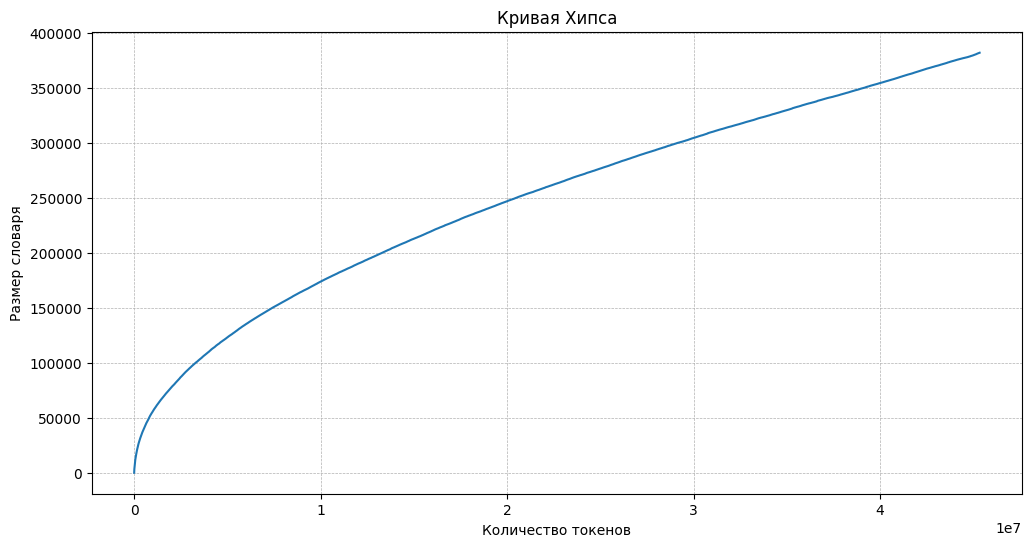

In [ ]:
def plot_heaps(words):
    vocab_size = []
    tokens_count = []
    unique_words = set()

    for i, word in enumerate(words):
        unique_words.add(word)
        if i % 100 == 0:
            vocab_size.append(len(unique_words))
            tokens_count.append(i + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(tokens_count, vocab_size)
    plt.title('Кривая Хипса')
    plt.xlabel('Количество токенов')
    plt.ylabel('Размер словаря')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

plot_heaps(words)

5. Ответьте на следующие вопросы:

а) какое слово встречается чаще, "сотрудник" или "клиент"?

б) сколько раз встречается слова "мошенничество" и "доверие"?

In [ ]:
# Инициализация лемматизатора
morph = pymorphy2.MorphAnalyzer()

# Загрузка стоп-слов для русского языка
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

# Функция для лемматизации
def lemmatize_words(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    words = text.split()
    lemmatized_words = []
    for word in words:
        if word not in russian_stopwords:
            parse = morph.parse(word)[0]
            lemmatized_words.append(parse.normal_form)
    return lemmatized_words

# Подсчет частот всех слов
word_counts = Counter()

# Загрузка и обработка данных построчно
with bz2.BZ2File('/content/banki_responses.json.bz2', 'r') as file:
    for line in file:
        review = json.loads(line.decode('utf-8'))
        text = review.get('text', '')
        lemmatized_words = lemmatize_words(text)
        word_counts.update(lemmatized_words)

# Проверка частоты интересующих слов
words_to_check = ['сотрудник', 'клиент', 'мошенничество', 'доверие']
for word in words_to_check:
    print(f"'{word}': {word_counts[word]} раз(а)")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'сотрудник': 165862 раз(а)
'клиент': 168096 раз(а)
'мошенничество': 3869 раз(а)
'доверие': 2723 раз(а)


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf−idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [10]:
# Загрузка стоп-слов для русского языка
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))
russian_stopwords.update(['это'])  # Добавление дополнительных стоп-слов

# Преобразование стоп-слов в список
russian_stopwords = list(russian_stopwords)

# Функция для предобработки текста
def preprocess_text(text):
    # Удаление специальных символов
    text = re.sub(r'[^\w\s]', '', text)
    # Приведение к нижнему регистру
    text = text.lower()
    return text

# Загрузка данных
with bz2.open('/content/banki_responses.json.bz2', 'rt', encoding='utf-8') as file:
    reviews = [json.loads(line) for line in file]

df = pd.DataFrame(reviews)

# Получение положительных и отрицательных отзывов с предобработкой
positive_reviews = df[df['rating_grade'] == 5]['text'].apply(preprocess_text).tolist()
negative_reviews = df[df['rating_grade'] == 1]['text'].apply(preprocess_text).tolist()

# TF-IDF для нахождения ключевых слов и биграмм с учетом стоп-слов
tfidf_vectorizer = TfidfVectorizer(max_features=10, ngram_range=(1, 2), stop_words=russian_stopwords)

# Обработка положительных отзывов
positive_tfidf = tfidf_vectorizer.fit_transform(positive_reviews)
positive_features = tfidf_vectorizer.get_feature_names_out()

# Обработка отрицательных отзывов
negative_tfidf = tfidf_vectorizer.fit_transform(negative_reviews)
negative_features = tfidf_vectorizer.get_feature_names_out()

print("Ключевые слова для положительных отзывов:")
print(positive_features)

print("\nКлючевые слова для отрицательных отзывов:")
print(negative_features)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Ключевые слова для положительных отзывов:
['банк' 'банка' 'банке' 'время' 'день' 'деньги' 'карту' 'кредит' 'очень'
 'спасибо']

Ключевые слова для отрицательных отзывов:
['банк' 'банка' 'банке' 'день' 'деньги' 'заявление' 'карту' 'карты'
 'кредит' 'отделение']


В этом плане было бы неплохо добавить поиск по леммам, чтобы повысить разнообразие слов.

# Часть 2. Тематическое моделирование

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [14]:
# Загрузка стоп-слов
nltk.download('stopwords')

# Загрузка данных
with bz2.open('banki_responses.json.bz2', 'rt', encoding='utf-8') as file:
    reviews = [json.loads(line) for line in file]

df = pd.DataFrame(reviews)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Функция для предобработки текста
def preprocess_text(text):
    stop_words = set(stopwords.words('russian'))
    russian_stopwords.update(['это'])
    morph = pymorphy2.MorphAnalyzer()
    text = re.sub(r'\s+', ' ', text)  # Удаление лишних пробелов
    text = re.sub(r'[^\w\s]', '', text)  # Удаление знаков препинания
    words = text.lower().split()
    words = [morph.parse(word)[0].normal_form for word in words if word not in stop_words]
    return words

In [11]:
# Загрузка стоп-слов для русского языка
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))
russian_stopwords.update(['это'])  # Добавление дополнительных стоп-слов

# Функция для предобработки текста
def preprocess_text(text):
    # Удаление специальных символов
    text = re.sub(r'[^\w\s]', '', text)
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление стоп-слов
    words = text.split()
    return [word for word in words if word not in russian_stopwords]

# Загрузка данных
with bz2.open('/content/banki_responses.json.bz2', 'rt', encoding='utf-8') as file:
    reviews = [json.loads(line) for line in file]

df = pd.DataFrame(reviews)

# Выборка части текстов для анализа
sample_size = 5000
sample_reviews = df['text'].head(sample_size).apply(preprocess_text).tolist()

# Создание словаря и корпуса
dictionary = corpora.Dictionary(sample_reviews)
corpus = [dictionary.doc2bow(text) for text in sample_reviews]

# Увеличиваем количество проходов для лучшей сходимости
passes = 10

# Тематическое моделирование с разным числом тем
num_topics_list = [5, 7, 10]

bank_keywords = ['Сбербанк России', 'ВТБ-24', 'другой_банк']

for num_topics in num_topics_list:
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)
    print(f"\nТематическая модель с {num_topics} темами:")
    for idx, topic in lda_model.print_topics(-1):
        print(f"Тема {idx}: {topic}")

    # Поиск тем, в которых упоминаются конкретные банки
    bank_topics = {bank: [] for bank in bank_keywords}

    for idx, topic in lda_model.show_topics(formatted=False):
        topic_terms = [word for word, _ in topic]
        for bank in bank_keywords:
            if bank in topic_terms:
                bank_topics[bank].append((num_topics, topic_terms))

    # Вывод тем для конкретных банков
    for bank, topics in bank_topics.items():
        print(f"\nТемы для {bank}:")
        for num_topics, topic_terms in topics:
            print(f"Модель с {num_topics} темами: {topic_terms}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Тематическая модель с 5 темами:
Тема 0: 0.012*"деньги" + 0.010*"банка" + 0.010*"карты" + 0.009*"банк" + 0.009*"карту" + 0.005*"рублей" + 0.005*"счет" + 0.004*"средств" + 0.004*"заявление" + 0.004*"руб"
Тема 1: 0.002*"wallet" + 0.002*"qiwi" + 0.002*"the" + 0.001*"персональных" + 0.001*"гр" + 0.001*"обработку" + 0.001*"киви" + 0.001*"номер" + 0.001*"базы" + 0.001*"кошелек"
Тема 2: 0.014*"банка" + 0.010*"банк" + 0.006*"кредит" + 0.004*"день" + 0.004*"очень" + 0.003*"банке" + 0.003*"номер" + 0.003*"время" + 0.003*"сотрудники" + 0.003*"отделение"
Тема 3: 0.009*"банк" + 0.009*"вклада" + 0.008*"банка" + 0.007*"вклад" + 0.007*"договора" + 0.006*"договор" + 0.005*"кредита" + 0.005*"года" + 0.004*"страхования" + 0.004*"условия"
Тема 4: 0.001*"миль" + 0.001*"бонусные" + 0.001*"мили" + 0.001*"брс" + 0.001*"жалоб" + 0.001*"конторе" + 0.001*"брокера" + 0.001*"убытках" + 0.001*"обслуживаюсь" + 0.001*"прибылях"

Темы для Сбербанк России:

Темы для ВТБ-24:

Темы для другой_банк:

Тематическая модель с

Почему-то модель не достаёт темы для конкретных банков

# Часть 3. Классификация текстов

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение).

In [4]:
# Загрузка данных
with bz2.open('banki_responses.json.bz2', 'rt', encoding='utf-8') as file:
    reviews = [json.loads(line) for line in file]

df = pd.DataFrame(reviews)

In [5]:
# Убедитесь, что столбец 'rating_grade' существует
if 'rating_grade' not in df.columns:
    raise KeyError("The 'rating_grade' column is not present in the data.")

# Выборка данных
N1, N2 = 1000, 1000  # Ограничение по количеству отзывов
negative_reviews = df[df['rating_grade'] == 1].head(N1)
positive_reviews = df[df['rating_grade'] == 5].head(N2)
data = pd.concat([negative_reviews, positive_reviews])

# Предобработка текста
def preprocess_text(text):
    return re.sub(r'[^\w\s]', '', text.lower())

data['text'] = data['text'].apply(preprocess_text)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['rating_grade'], test_size=0.2, random_state=42)

2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n-грам.

In [6]:
# Векторизация текста
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Классификация и получение baseline
classifier = MultinomialNB()
classifier.fit(X_train_vec, y_train)
y_pred = classifier.predict(X_test_vec)

# Оценка качества
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Baseline accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")

Baseline accuracy: 0.87, F1 Score: 0.87


3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

1-ый вариант:tf−idf преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD)

2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [7]:
# Использование скрытых тем: LSA
svd = TruncatedSVD(n_components=500, random_state=42)
pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 3)), svd, LogisticRegression())
pipeline.fit(X_train, y_train)
y_pred_lsa = pipeline.predict(X_test)
accuracy_lsa = accuracy_score(y_test, y_pred_lsa)
f1_lsa = f1_score(y_test, y_pred_lsa, average='weighted')
print(f"LSA accuracy: {accuracy_lsa:.2f}, F1 Score: {f1_lsa:.2f}")

LSA accuracy: 0.87, F1 Score: 0.87


In [27]:
# Использование скрытых тем: LDA
# Шаг 1: Векторизация текста
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Ограничиваем количество признаков

# Шаг 2: Тематическое моделирование
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 тем

# Шаг 3: Классификация
classifier = LogisticRegression(max_iter=2000, random_state=42)

# Создаем pipeline
pipeline_lda = make_pipeline(tfidf_vectorizer, lda, classifier)

# Обучаем pipeline
pipeline_lda.fit(X_train, y_train)

# Предсказание и оценка
y_pred_lda = pipeline_lda.predict(X_test)
accuracy_lda = accuracy_score(y_test, y_pred_lda)
f1_lda = f1_score(y_test, y_pred_lda, average='weighted')

print(f"LDA accuracy: {accuracy_lda:.2f}, F1 Score: {f1_lda:.2f}")

LDA accuracy: 0.89, F1 Score: 0.88
